In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

import UCI_loader
import importlib

In [73]:
# network class
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,2) 
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e/h))
    loss= torch.mean(loss)*h
    return loss

def check_loss(x, y, tau): # the x,*args way to pass arguments to this function is an idiom for the scipy.optimize() library y = args[0][0]
    e = y-x
    ind = (torch.sign(-e)+1)/2
    loss = torch.mean(e*(tau-ind))
    return loss

class TiltedLC(nn.Module):
    def __init__(self):
        super(TiltedLC, self).__init__()
    def forward(self, x, y, tau, h):
        return tiltedLC(x, y, tau, h)


class CheckLC(nn.Module):
    def __init__(self):
        super(CheckLC, self).__init__()
    def forward(self, x, y, tau):
        return check_loss(x, y, tau)

# Getting the data
importlib.reload(UCI_loader)
data= UCI_loader.UCIDatasets("energy") 
train_data= data.get_split()
test_data= data.get_split(train=False)


# instantiating the network for training on this dataset
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model= Network(indim=8).to(device=device)
tau= 0.5
h= 0.1

criterion1= TiltedLC()
criterion2= CheckLC()
optimizer= optim.Adam(model.parameters())
ls_a= []
ls_b= []

In [74]:
# the fundamental training loop
 # instantiating the DataLoader
trainloader = torch.utils.data.DataLoader(
                    train_data,
                    batch_size=16,
                    shuffle=True)
N_EPOCHS = 10
for epoch in range(N_EPOCHS): 
    epoch_loss1 = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss1= criterion1(outputs, labels, tau, h) 
        loss1.backward() 
        optimizer.step() 
        epoch_loss1+= loss1.item() 
    ls_a.append(epoch_loss1/len(trainloader))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss1/len(trainloader)))

Epoch: 0 Loss: 0.22108007717708295
Epoch: 1 Loss: 0.08386559975968505
Epoch: 2 Loss: 0.07984467870979146
Epoch: 3 Loss: 0.07480643909763206
Epoch: 4 Loss: 0.072345423723825
Epoch: 5 Loss: 0.07023836325176737
Epoch: 6 Loss: 0.06746367271989584
Epoch: 7 Loss: 0.06582603573968465
Epoch: 8 Loss: 0.06342427280138839
Epoch: 9 Loss: 0.06152072007005865


In [75]:
for epoch in range(N_EPOCHS): 
    epoch_loss2 = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss2= criterion2(outputs, labels, tau)
        loss2.backward() 
        optimizer.step() 
        epoch_loss2+= loss2.item() 
    ls_b.append(epoch_loss2/len(trainloader))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss2/len(trainloader)))

Epoch: 0 Loss: 0.08558289423076944
Epoch: 1 Loss: 0.08384346411648122
Epoch: 2 Loss: 0.07831008097326214
Epoch: 3 Loss: 0.07480453572828662
Epoch: 4 Loss: 0.0750468901612542
Epoch: 5 Loss: 0.07547562967308542
Epoch: 6 Loss: 0.07197858731855046
Epoch: 7 Loss: 0.06879337800836022
Epoch: 8 Loss: 0.07128839651969346
Epoch: 9 Loss: 0.06468191565099088


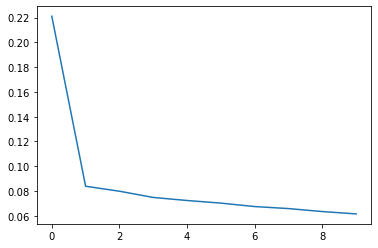

In [84]:
plt.plot(range(N_EPOCHS), ls_a) # log-cosh
# plt.plot(range(N_EPOCHS), ls_b) # check